# Profile KMeans

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time

# Parse ISDF profiling times
results_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

isdf_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    isdf_results[dir] = {'cumulative': cumulative, 'self':self}


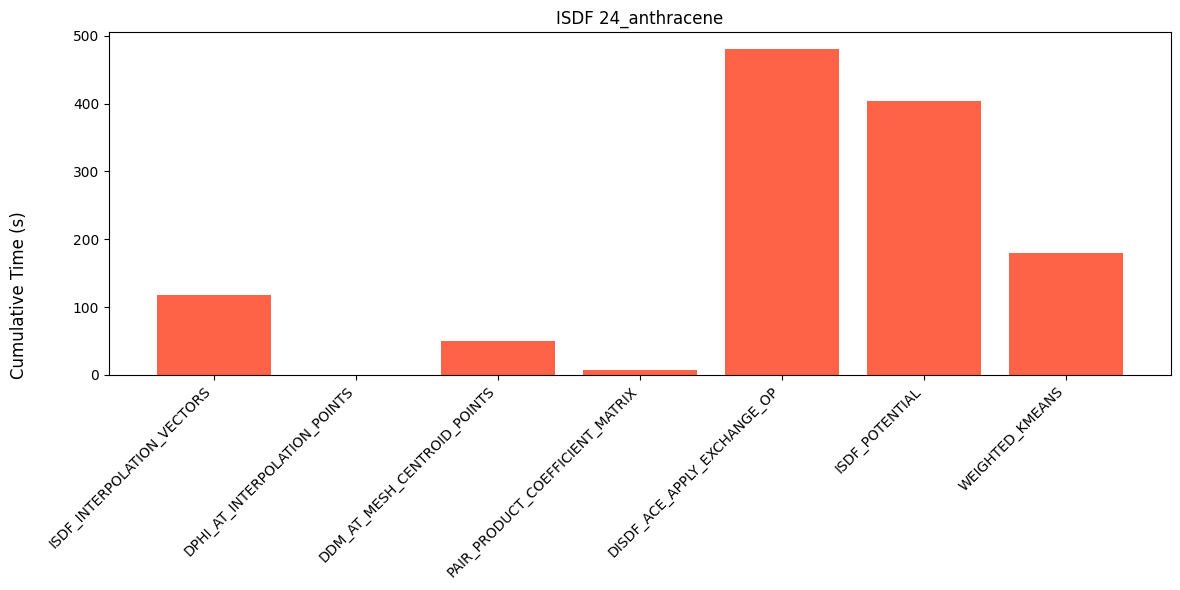

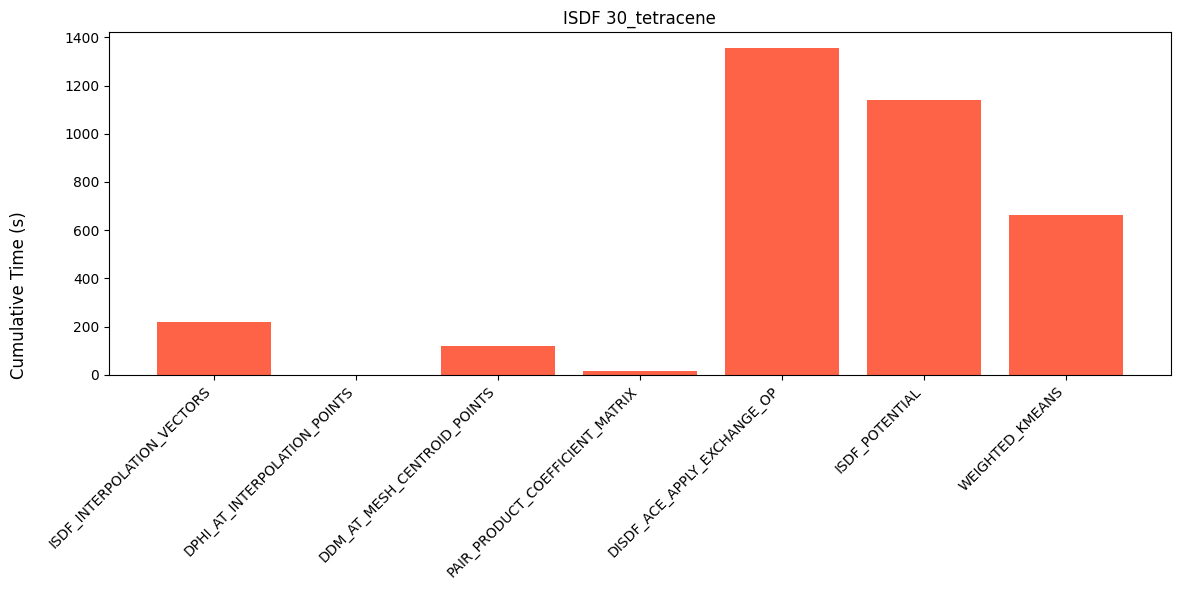

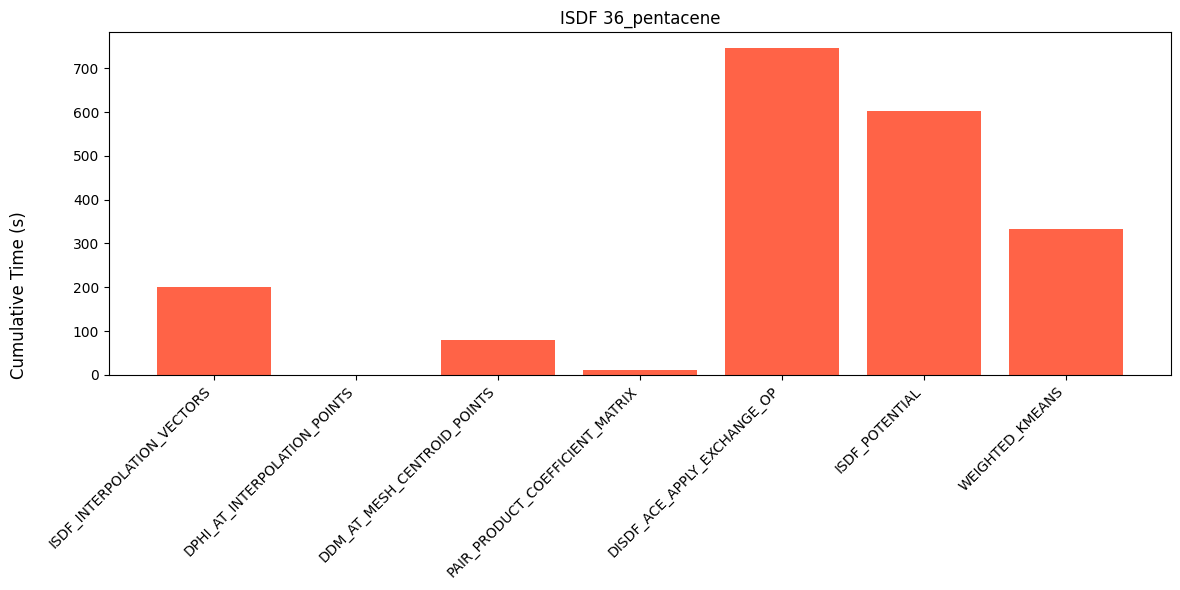

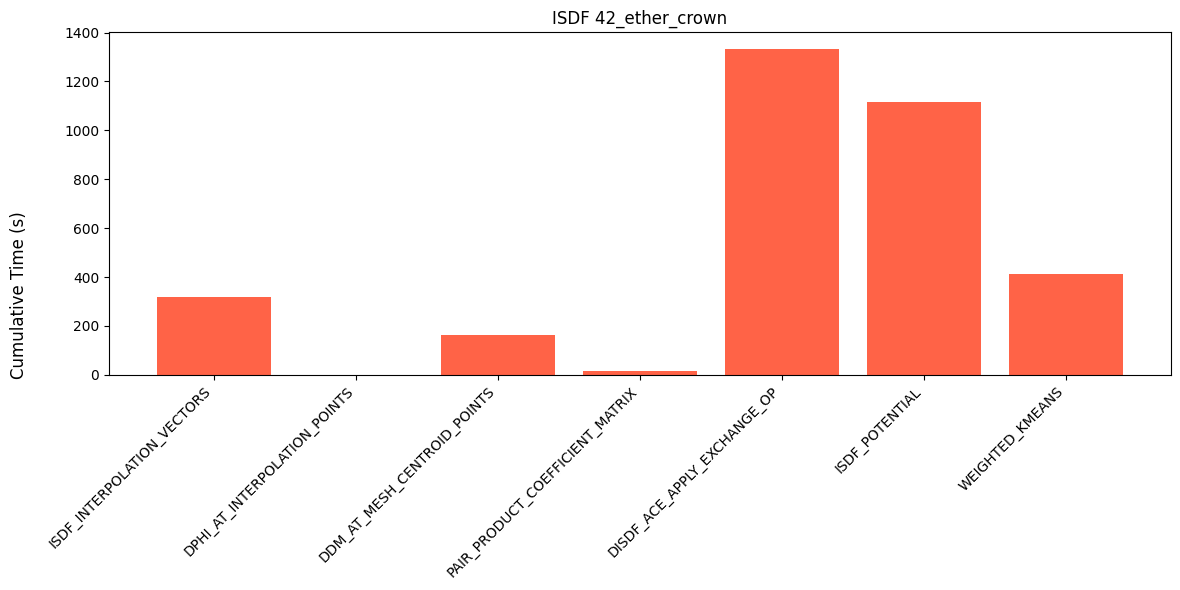

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL',
            'WEIGHTED_KMEANS']

# Plotting.
for dir in directories:
    fig, ax_isdf = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
    add_bars(ax_isdf, isdf_routines, to_total_time(isdf_results[dir]['cumulative'], isdf_routines), color='tomato')
    ax_isdf.set_title(f'ISDF {dir}')
    fig.supylabel('Cumulative Time (s)')
    fig.tight_layout()

In [10]:
import re
from typing import List
""" Convergence in KMeans as a function of SCF Iteration
"""


def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return [int(n) for n in pat.findall(text)]


results_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]
print(parse_kmeans_iterations(results_root / "24_anthracene/terminal.out"))



[129, 63, 45, 40, 32, 28, 32, 24, 30, 31, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


In [ ]:
# Repeat but with an improved criterion

# Repeat with the second criterion added as well

# In all cases, compare the final energy error
